### Pinchout Example
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases how with one parameter (Z_controlpoint), multiple structural models can be generated for a pinched out layer at an unconformity using a 3D synthetic example. Corresponding flow models are automatically generated and run due to the seamless workflow. Results show significantly different head distributions for eack structural model.

### 1. Project parameters

In [17]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [18]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference

P.xypumpbores = [] 
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (2500, 2500), (5000,5000)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
P.zobs = [-40, -50, -100, -200, -300]
P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100       # Interior boundary
P.boundmaxtri = 50000 # 8/5 - was 20000
P.modelmaxtri = 50000 # 8/5 - was 30000
P.angle = 32   # minimum triangle angles
P.nlv  = 30    

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 99999

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable

P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = False

P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)

### Pinchouts - multiple simulations

In [19]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

In [20]:
options = np.linspace(-250, 0, 6) # control point z values

pinchout_modelnames, pinchout_models, pinchout_obs_heads = [],[],[]        
heads = []

for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    pinchout_obs_heads.append((process_obs(P, M)))
    heads.append((M.head_ss))
    f = os.path.join(vtk_workspace, "pinchouts", M.modelname)
    M.gwf.export(f, fmt="vtk")

C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-250.0  ...
Time taken =  2.778593
Creating property arrays for  PO_-250.0  ...
Time taken =  0.018453
Adding flow packages to  PO_-250.0  ...
Time taken =  1.067822
Writing simulation and gwf for  PO_-250.0  ...
PO_-250.0
Running simulation for  PO_-250.0  ...
Period =  Steady 
Model success =  True
run_time =  11.763321


C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-200.0  ...
Time taken =  2.43433
Creating property arrays for  PO_-200.0  ...
Time taken =  0.01012
Adding flow packages to  PO_-200.0  ...
Time taken =  0.851265
Writing simulation and gwf for  PO_-200.0  ...
PO_-200.0
Running simulation for  PO_-200.0  ...
Period =  Steady 
Model success =  True
run_time =  17.574118


C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-150.0  ...
Time taken =  3.018084
Creating property arrays for  PO_-150.0  ...
Time taken =  0.010126
Adding flow packages to  PO_-150.0  ...
Time taken =  1.593875
Writing simulation and gwf for  PO_-150.0  ...
PO_-150.0
Running simulation for  PO_-150.0  ...
Period =  Steady 
Model success =  True
run_time =  10.186985


C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-100.0  ...
Time taken =  2.57092
Creating property arrays for  PO_-100.0  ...
Time taken =  0.009001
Adding flow packages to  PO_-100.0  ...
Time taken =  0.786839
Writing simulation and gwf for  PO_-100.0  ...
PO_-100.0
Running simulation for  PO_-100.0  ...
Period =  Steady 
Model success =  True
run_time =  9.252399


C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-50.0  ...
Time taken =  2.634528
Creating property arrays for  PO_-50.0  ...
Time taken =  0.014658
Adding flow packages to  PO_-50.0  ...
Time taken =  0.968815
Writing simulation and gwf for  PO_-50.0  ...
PO_-50.0
Running simulation for  PO_-50.0  ...
Period =  Steady 
Model success =  True
run_time =  10.281865


C:\Users\19904604\Anaconda3\envs\loop3denv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_0.0  ...
Time taken =  2.971358
Creating property arrays for  PO_0.0  ...
Time taken =  0.010089
Adding flow packages to  PO_0.0  ...
Time taken =  1.213784
Writing simulation and gwf for  PO_0.0  ...
PO_0.0
Running simulation for  PO_0.0  ...
Period =  Steady 
Model success =  True
run_time =  8.30934


In [21]:
heads_A = find_watertable_disu(P, M = pinchout_models[-1], layer = 2)
heads_B = find_watertable_disu(P, M = pinchout_models[0], layer = 2)

C:\Users\19904604\AppData\Local\Temp\ipykernel_16048\398711091.py:6: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


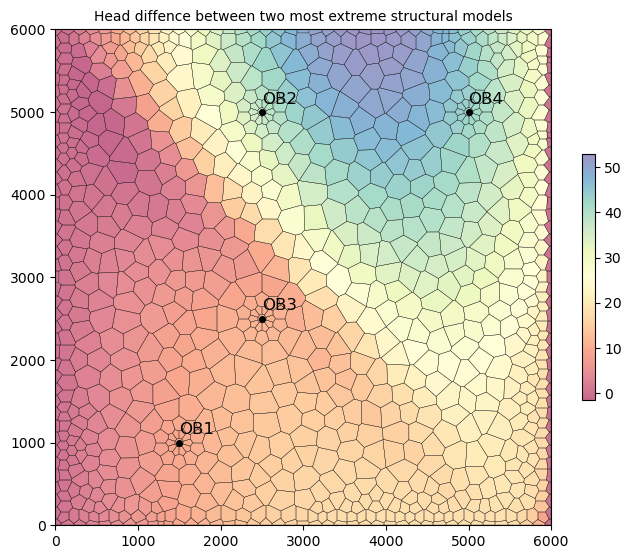

In [22]:
plot_head_diff(P, pinchout_models[0], heads_A, heads_B)

C:\Users\19904604\AppData\Local\Temp\ipykernel_16048\449695775.py:13: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


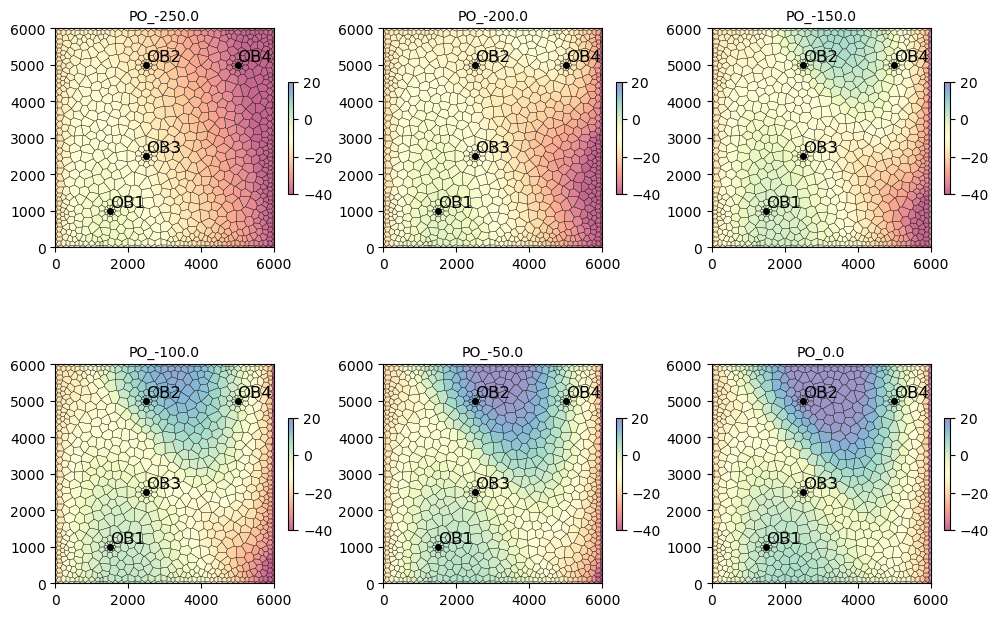

In [23]:
plot_bylayer(P, models = pinchout_models, layer = 2, vmin = -40, vmax = 20) 

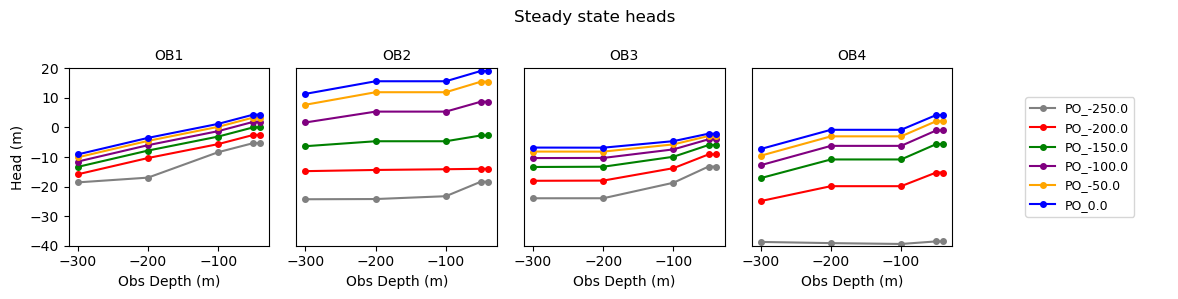

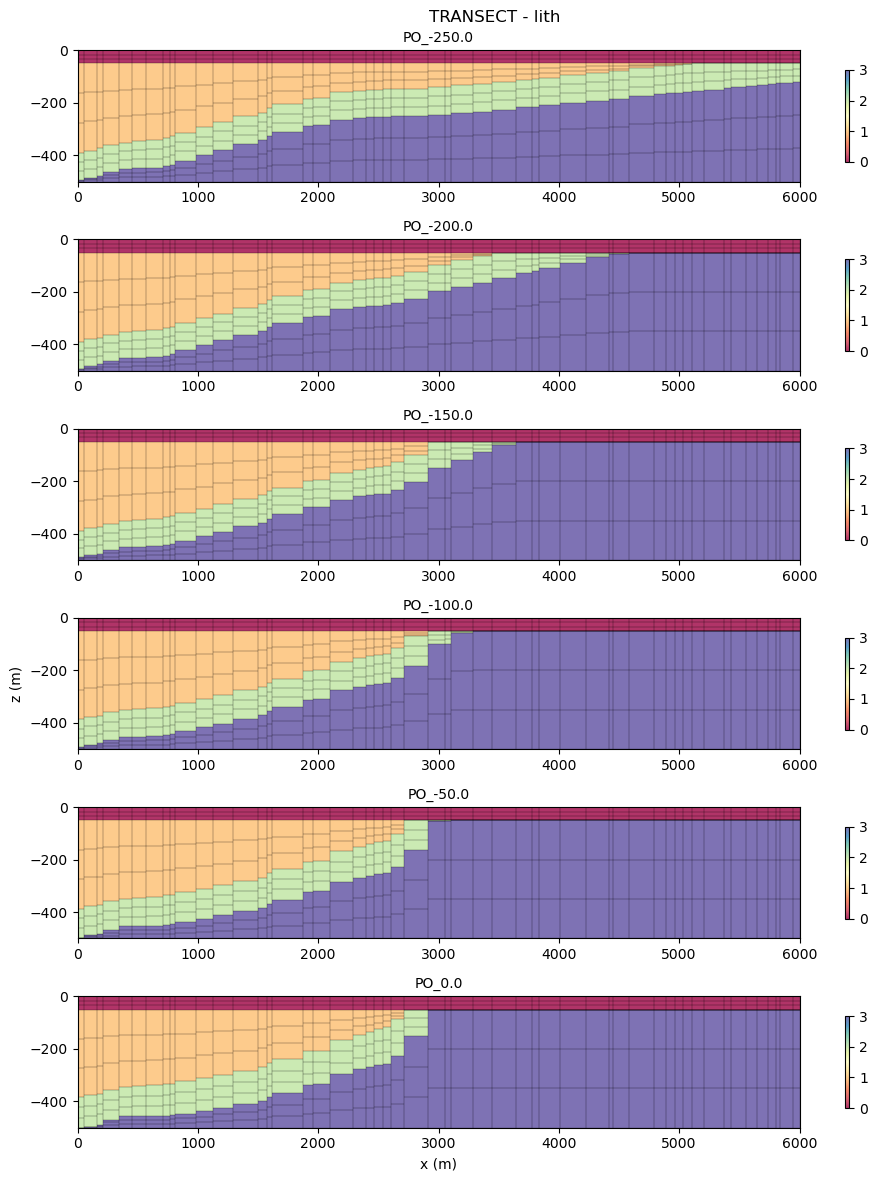

In [24]:
# Plot multiple sims
plot_observations(ylim = [-40, 20], modelnames = pinchout_modelnames, heads = pinchout_obs_heads)
multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

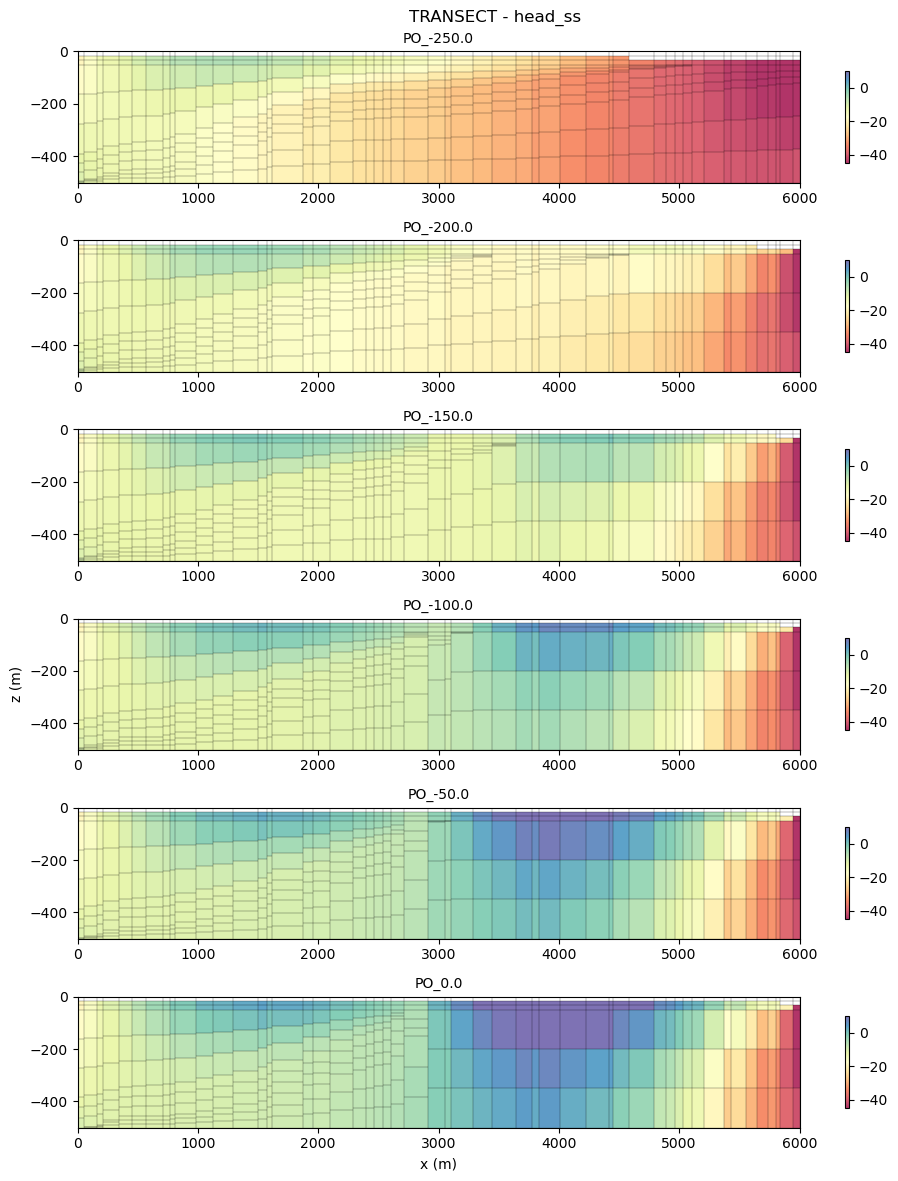

In [25]:
multiplot_prop_transect(P, models = pinchout_models, array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 10)